In [9]:
using DataFrames
using CSV
using Plots
using StatsPlots
pyplot()

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1242


Plots.PyPlotBackend()

In [5]:
@time sensor_data = CSV.read("sensor-data.csv");

  0.209830 seconds (14.38 k allocations: 856.945 KiB)


In [6]:
first(sensor_data, 10)

,Column1,timestamp,x,y,z,alpha,beta,gamma
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0,1.56983e9,-2.02528,-0.824988,0.138677,-8.34027e-5,-0.00199491,-1.45129e-5
2,1,1.56983e9,-1.97991,-0.824997,0.138671,-7.03635e-5,-0.00210816,-0.000275701
3,2,1.56983e9,-1.90681,-0.825029,0.138671,-7.25578e-5,-0.00208382,-0.000199489
4,3,1.56983e9,-1.83362,-0.825041,0.138692,-8.3954e-5,-0.00152187,-0.000145771
5,4,1.56983e9,-1.78487,-0.825051,0.138702,-6.22464e-5,-0.00143969,-0.000128185
6,5,1.56983e9,-1.71176,-0.82506,0.138698,-6.7272e-5,-0.00145672,-0.000130821
7,6,1.56983e9,-1.66304,-0.825064,0.138695,-7.85449e-5,-0.0015591,-0.000122266
8,7,1.56983e9,-1.61429,-0.825076,0.138696,-7.8043e-5,-0.00152256,-0.000123342
9,8,1.56983e9,-1.54119,-0.825072,0.138693,-8.16519e-5,-0.00162466,-0.000122423


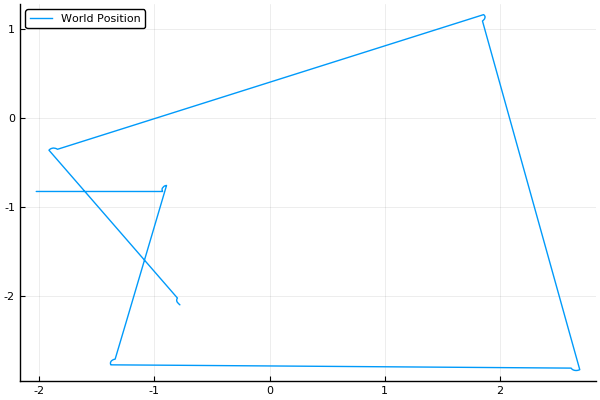

In [11]:
@df sensor_data plot(:x, :y, label="World Position")